### Data preparation
We start by loading the data and spliting the train, validation, and test sets. 

Or you can load the data and start the code from <a href='#load_pkl'>here</a>.

In [1]:
import os
import re
import random
import pickle as pkl
import time

In [3]:
def importData(data_directory, shuffle=True):
    orig_data = []
    pos_file_ls = os.listdir(data_directory + '/pos/')
    neg_file_ls = os.listdir(data_directory + '/neg/')
    for file_ in pos_file_ls:
        file_pos = 1
        with open(data_directory + '/pos/' + file_, 'r') as f:
            file_text = f.read()
        file_rate = int((file_.split('_')[1]).split('.')[0])
        orig_data.append((file_pos, file_text, file_rate))
    for file_ in neg_file_ls:
        file_pos = 0
        with open(data_directory + '/neg/' + file_, 'r') as f:
            file_text = f.read()
        file_rate = int((file_.split('_')[1]).split('.')[0])
        orig_data.append((file_pos, file_text, file_rate))
    if shuffle:
        random.shuffle(orig_data)
    return orig_data

IndentationError: unexpected indent (<ipython-input-3-269b736d430c>, line 2)

In [44]:
orig_train = importData('../../aclImdb/train/')
orig_test = importData('../../aclImdb/test/')

In [418]:
# split train data into actual train and validation sets
train_split = 20000

train_data = [x[1] for x in orig_train[:train_split]]
train_targets = [x[0] for x in orig_train[:train_split]]

val_data = [x[1] for x in orig_train[train_split:]]
val_targets = [x[0] for x in orig_train[train_split:]]

test_data = [x[1] for x in orig_test]
test_targets = [x[0] for x in orig_test]

print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

pkl.dump(train_targets, open('./train_targets.p', 'wb'))
pkl.dump(val_targets, open('./val_targets.p', 'wb'))
pkl.dump(test_targets, open('./test_targets.p', 'wb'))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


### Tokenize the dataset
We tokenize the dataset with spacy.io

In [180]:
import spacy
import string

tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent.replace('<br />', ''))
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]

In [183]:
import pickle as pkl

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
#     all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens) 
#         all_tokens += tokens 

    return token_dataset #, all_tokens

# val set tokens
print ("Tokenizing val data")
val_data_tokens= tokenize_dataset(val_data)
pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_tokens= tokenize_dataset(test_data)
pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens = tokenize_dataset(train_data)
pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))

Tokenizing val data
Tokenizing test data
Tokenizing train data


In [57]:
def create_all_tokens(data_tokens):
    all_tokens = [[] for x in range(4)]
    for sent_ in data_tokens:
        l = len(sent_)
        all_tokens[0] += sent_
        all_tokens[1] += [(sent_[i], sent_[i+1]) for i in range(l-1)]
        all_tokens[2] += [(sent_[i], sent_[i+1], sent_[i+2]) for i in range(l-2)]
        all_tokens[3] += [(sent_[i], sent_[i+1], sent_[i+2], sent_[i+3]) for i in range(l-3)]
    return all_tokens

In [408]:
# Create "all_token"
# a list of 1, 2, 3, and 4-gram tokens
def create_all_tokens(data_tokens):
    all_tokens = [[] for x in range(4)]
    for sent_ in data_tokens:
        l = len(sent_)
        all_tokens[0] += sent_
        all_tokens[1] += [(sent_[i], sent_[i+1]) for i in range(l-1)]
        all_tokens[2] += [(sent_[i], sent_[i+1], sent_[i+2]) for i in range(l-2)]
        all_tokens[3] += [(sent_[i], sent_[i+1], sent_[i+2], sent_[i+3]) for i in range(l-3)]
    return all_tokens

all_train_tokens = create_all_tokens(train_data_tokens)
pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

<div id=load_pkl> If you wish to use the pickle file, please start from the following cell</div>

In [3]:
import os
import re
import random
import pickle as pkl
import time
val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
test_data_tokens= pkl.load(open("test_data_tokens.p", "rb"))
train_data_tokens=pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens= pkl.load(open("all_train_tokens.p", "rb"))

train_targets = pkl.load(open('./train_targets.p', 'rb'))
val_targets = pkl.load(open('./val_targets.p', 'rb'))
test_targets = pkl.load(open('./test_targets.p', 'rb'))

In [4]:
# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))
print ("Total number of tokens in train dataset is {}, {}, {}, {}".format(*[len(x) for x in all_train_tokens]))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4759556, 4739556, 4719556, 4699556


Create the vocabulary of the most common 10,000 1, 2, 3, 4-gram tokens respectively in the training set

In [5]:
from collections import Counter

max_vocab_size = 20000
n_gram = 2
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, n_gram):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    id2token = ['<pad>', '<unk>']
    token2id = dict()
    token_counter = Counter(sum(all_tokens[:n_gram], []))
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    token2id.update(dict(zip(vocab, range(len(id2token),len(id2token)+len(vocab)))))
    id2token += list(vocab)
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens, n_gram)

In [48]:
# convert token to id and add n-gram indices in the dataset
def token2index_dataset(tokens_data, n_gram, token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = []
        l = len(tokens)
        # 1-gram
        if n_gram >=1:
            index_list.extend( [token2id[tokens[i]] if tokens[i] in token2id else UNK_IDX for i in range(l)])
        # 2-gram
        if n_gram >= 2:
            index_list.extend( [token2id[(tokens[i], tokens[i+1])] \
                            if (tokens[i], tokens[i+1]) in token2id else UNK_IDX for i in range(l-1)])
        # 3-gram
        if n_gram >= 3:
            index_list.extend( [token2id[(tokens[i], tokens[i+1], tokens[i+2])] \
                            if (tokens[i], tokens[i+1], tokens[i+2]) in token2id else UNK_IDX for i in range(l-2)])
        # 4-gram
        if n_gram >= 4:
            index_list.extend( [token2id[(tokens[i], tokens[i+1], tokens[i+2], tokens[i+3])] \
                            if (tokens[i], tokens[i+1], tokens[i+2], tokens[i+3]) in token2id else UNK_IDX for i in range(l-3)])
        indices_data.append(index_list)
    return indices_data

In [6]:
train_data_indices = token2index_dataset(train_data_tokens, n_gram, token2id)
val_data_indices = token2index_dataset(val_data_tokens, n_gram, token2id)
test_data_indices = token2index_dataset(test_data_tokens, n_gram, token2id)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


### Preparing the dataloader
The dataloader now load all n-gram indicies for the model to choose. 

In [7]:
# NOTE: we will truncate the sentence to MAX_SENTENCE_LENGTH * n_gram, not MAX_SENTENCE_LENGTH
MAX_SENTENCE_LENGTH = 1000


import numpy as np
import torch
from torch.utils.data import Dataset

class ImdbDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, n_gram):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        self.n_gram = n_gram
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        Note that the first item returned is a list of n-grams tokens
        """
        
        token_idx = self.data_list[key][:(MAX_SENTENCE_LENGTH * self.n_gram)]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length (all data, sentence has the same length; so we can
    convert it into a matrix and further into a tensor)
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = []
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=(0,MAX_SENTENCE_LENGTH * n_gram - datum[1]), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]


BATCH_SIZE = 64
train_dataset = ImdbDataset(train_data_indices, train_targets, n_gram)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = ImdbDataset(val_data_indices, val_targets, n_gram)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

test_dataset = ImdbDataset(test_data_indices, test_targets, n_gram)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)

In [8]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import pdb  


class BagOfNGram(nn.Module):
    """
    BagOfNGram classification model
    """
    def __init__(self, vocab_size, emb_dim, n_gram):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        @param n_in_n_gram: the n in n-gram
        """
        super(BagOfNGram, self).__init__()
        # calculating the vocabulary size
        self.n_gram = n_gram
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        # nn.Embedding: The table lookup
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
#         pdb.set_trace()
        length = length
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out



In [9]:
import matplotlib.pyplot as plt
learning_rate = 0.01
num_epochs = 5 # number epoch to train

# Criterion and Optimizer


# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = (F.softmax(model(data_batch.cuda(), length_batch.cuda()), dim=1)).cpu()
        predicted = outputs.max(1, keepdim=True)[1] # The second output is the index of the largest output
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

def run_model_conf(n_gram, emb_dim, num_epochs, learning_rate,
                          fig_name):
    model = BagOfNGram(len(id2token), emb_dim, n_gram).cuda()
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return run_model(model, criterion, optimizer, num_epochs, fig_name)

def run_model(model, criterion, optimizer, num_epochs, fig_name):
    '''
    Main function to train the model.
    '''
    iter_num= 0
    record = {
        'iter_num':[],
        'val_acc':[],
        'train_acc':[]
    }
    
    # Initialize model
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            iter_num += 1
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch.cuda(), length_batch.cuda())
            loss = criterion(outputs.cpu(), label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and (i+1) % 50 == 0:
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                record['iter_num'].append(iter_num)
                record['val_acc'].append(val_acc)
                record['train_acc'].append(train_acc)
            del outputs
        val_acc = test_model(val_loader, model)
        print('Epoch: [{}/{}], Validation Acc: {}'.format( 
                   epoch+1, num_epochs, val_acc))
            
    plt.clf()
    plt.cla()
    plt.plot(record['iter_num'], record['val_acc'], label = 'Val Acc')
    plt.plot(record['iter_num'], record['train_acc'], label = 'Train Acc')
    plt.legend()
    plt.savefig('./img/'+fig_name+'.png')
    plt.savefig('./img/'+fig_name+'.eps')
    plt.show()
    torch.cuda.empty_cache()
    return model, record

### Baseline model
We now run a baseline model, configurations are:

| n-gram | vocabulary size | embedding size | max_sentence_length | learning_rate | optimizer | epoch, batch_size |
| ------ | --------------- | -------------- | ------------------- | ------------- | --------- | ----- |
| 2 | 20000 | 100| 1000 | 0.01 | Adam | 10, 64 |

Epoch: [1/10], Validation Acc: 89.8
Epoch: [2/10], Validation Acc: 89.64
Epoch: [3/10], Validation Acc: 88.62
Epoch: [4/10], Validation Acc: 88.96
Epoch: [5/10], Validation Acc: 88.8
Epoch: [6/10], Validation Acc: 88.96
Epoch: [7/10], Validation Acc: 88.94
Epoch: [8/10], Validation Acc: 88.94
Epoch: [9/10], Validation Acc: 88.8
Epoch: [10/10], Validation Acc: 88.96


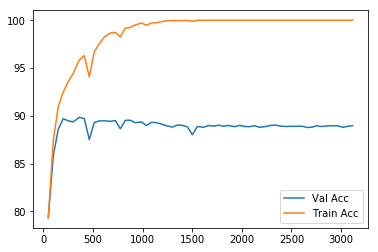

In [10]:
mdl, rec = run_model_conf(2, 200, 10, 0.01,  'baseline')

### Hyperparameters exploring

#### n-gram

| n-gram | vocabulary size | embedding size | max_sentence_length | learning_rate | optimizer | epoch |
| ------ | --------------- | -------------- | ------------------- | ------------- | --------- | ----- |
| **[1, 2, 3 ,4]** | 20000 | 200| 1000 | 0.01 | Adam | 10 |

---Running n-gram = 1---
Epoch: [1/10], Validation Acc: 88.32
Epoch: [2/10], Validation Acc: 88.38
Epoch: [3/10], Validation Acc: 87.94
Epoch: [4/10], Validation Acc: 87.9
Epoch: [5/10], Validation Acc: 87.26
Epoch: [6/10], Validation Acc: 87.8
Epoch: [7/10], Validation Acc: 87.48
Epoch: [8/10], Validation Acc: 87.62
Epoch: [9/10], Validation Acc: 87.58
Epoch: [10/10], Validation Acc: 87.78


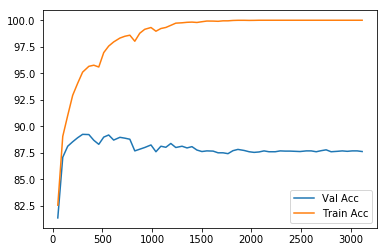

---Running n-gram = 2---
Epoch: [1/10], Validation Acc: 89.86
Epoch: [2/10], Validation Acc: 89.98
Epoch: [3/10], Validation Acc: 89.36
Epoch: [4/10], Validation Acc: 89.12
Epoch: [5/10], Validation Acc: 88.64
Epoch: [6/10], Validation Acc: 88.86
Epoch: [7/10], Validation Acc: 88.84
Epoch: [8/10], Validation Acc: 88.78
Epoch: [9/10], Validation Acc: 88.84
Epoch: [10/10], Validation Acc: 88.7


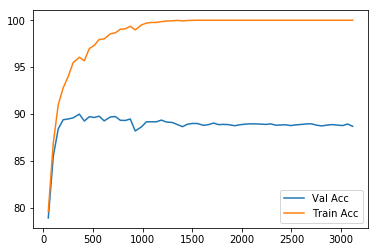

---Running n-gram = 3---
Epoch: [1/10], Validation Acc: 89.4
Epoch: [2/10], Validation Acc: 89.44
Epoch: [3/10], Validation Acc: 89.06
Epoch: [4/10], Validation Acc: 88.2
Epoch: [5/10], Validation Acc: 88.8
Epoch: [6/10], Validation Acc: 88.8
Epoch: [7/10], Validation Acc: 88.58
Epoch: [8/10], Validation Acc: 89.02
Epoch: [9/10], Validation Acc: 88.76
Epoch: [10/10], Validation Acc: 88.76


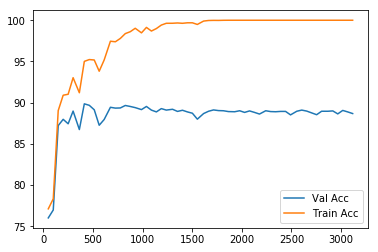

---Running n-gram = 4---
Epoch: [1/10], Validation Acc: 86.96
Epoch: [2/10], Validation Acc: 89.76
Epoch: [3/10], Validation Acc: 89.4
Epoch: [4/10], Validation Acc: 88.74
Epoch: [5/10], Validation Acc: 88.68
Epoch: [6/10], Validation Acc: 88.8
Epoch: [7/10], Validation Acc: 88.98
Epoch: [8/10], Validation Acc: 88.76
Epoch: [9/10], Validation Acc: 88.98
Epoch: [10/10], Validation Acc: 88.94


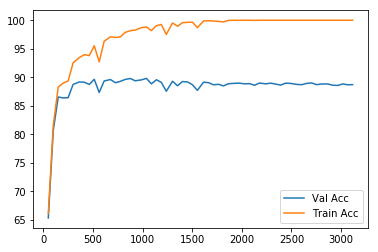

In [31]:
for i in range(1, 5):
    print('---Running n-gram = {}---'.format(i))
    n_gram = i
    # Redo the data preparation
    token2id, id2token = build_vocab(all_train_tokens, n_gram)
    train_data_indices = token2index_dataset(train_data_tokens, n_gram)
    val_data_indices = token2index_dataset(val_data_tokens, n_gram)
    test_data_indices = token2index_dataset(test_data_tokens, n_gram)
    train_dataset = ImdbDataset(train_data_indices, train_targets, n_gram)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    val_dataset = ImdbDataset(val_data_indices, val_targets, n_gram)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    test_dataset = ImdbDataset(test_data_indices, test_targets, n_gram)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)
    # run the model
    _, rec = run_model_conf(i, 200, 10, 0.01,  'nGram_{}'.format(i))

#### Vocabulary Size

| n-gram | vocabulary size | embedding size | max_sentence_length | learning_rate | optimizer | epoch |
| ------ | --------------- | -------------- | ------------------- | ------------- | --------- | ----- |
| 2 | **[10000, 20000, 30000, 40000]**| 200| 1000 | 0.01 | Adam | 10 |

---Running max vocab = 10000---
Epoch: [1/10], Validation Acc: 85.82
Epoch: [2/10], Validation Acc: 89.2
Epoch: [3/10], Validation Acc: 89.32
Epoch: [4/10], Validation Acc: 87.52
Epoch: [5/10], Validation Acc: 88.78
Epoch: [6/10], Validation Acc: 87.96
Epoch: [7/10], Validation Acc: 87.94
Epoch: [8/10], Validation Acc: 86.68
Epoch: [9/10], Validation Acc: 87.38
Epoch: [10/10], Validation Acc: 87.44


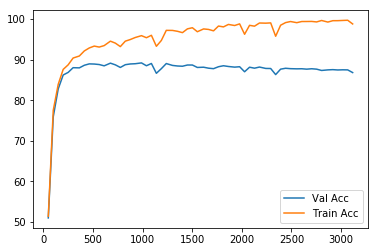

---Running max vocab = 20000---
Epoch: [1/10], Validation Acc: 87.44
Epoch: [2/10], Validation Acc: 89.7
Epoch: [3/10], Validation Acc: 89.44
Epoch: [4/10], Validation Acc: 89.4
Epoch: [5/10], Validation Acc: 88.62
Epoch: [6/10], Validation Acc: 88.64
Epoch: [7/10], Validation Acc: 88.9
Epoch: [8/10], Validation Acc: 88.98
Epoch: [9/10], Validation Acc: 88.9
Epoch: [10/10], Validation Acc: 88.98


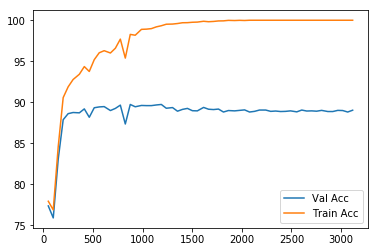

---Running max vocab = 30000---
Epoch: [1/10], Validation Acc: 86.84
Epoch: [2/10], Validation Acc: 89.82
Epoch: [3/10], Validation Acc: 89.86
Epoch: [4/10], Validation Acc: 89.58
Epoch: [5/10], Validation Acc: 89.2
Epoch: [6/10], Validation Acc: 89.7
Epoch: [7/10], Validation Acc: 89.56
Epoch: [8/10], Validation Acc: 89.56
Epoch: [9/10], Validation Acc: 89.6
Epoch: [10/10], Validation Acc: 89.52


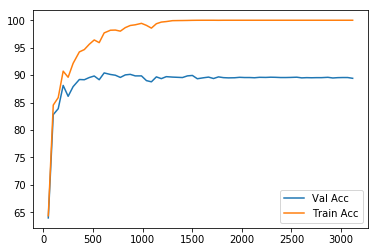

---Running max vocab = 50000---
Epoch: [1/10], Validation Acc: 89.82
Epoch: [2/10], Validation Acc: 90.24
Epoch: [3/10], Validation Acc: 90.16
Epoch: [4/10], Validation Acc: 90.46
Epoch: [5/10], Validation Acc: 90.54
Epoch: [6/10], Validation Acc: 90.62
Epoch: [7/10], Validation Acc: 90.46
Epoch: [8/10], Validation Acc: 90.64
Epoch: [9/10], Validation Acc: 90.62
Epoch: [10/10], Validation Acc: 90.62


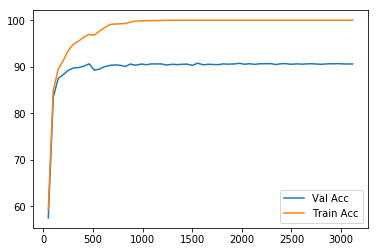

---Running max vocab = 80000---
Epoch: [1/10], Validation Acc: 90.78
Epoch: [2/10], Validation Acc: 90.7
Epoch: [3/10], Validation Acc: 90.64
Epoch: [4/10], Validation Acc: 90.84
Epoch: [5/10], Validation Acc: 90.82
Epoch: [6/10], Validation Acc: 90.8
Epoch: [7/10], Validation Acc: 90.8
Epoch: [8/10], Validation Acc: 90.66
Epoch: [9/10], Validation Acc: 90.78
Epoch: [10/10], Validation Acc: 90.7


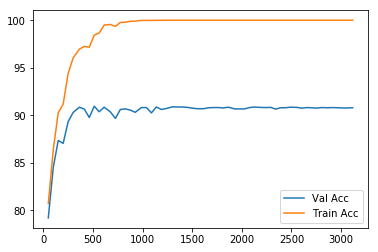

In [32]:
for i in [10000, 20000, 30000, 50000, 80000]:
    print('---Running max vocab = {}---'.format(i))
    max_vocab_size = i
    token2id, id2token = build_vocab(all_train_tokens, n_gram)
    train_data_indices = token2index_dataset(train_data_tokens, n_gram)
    val_data_indices = token2index_dataset(val_data_tokens, n_gram)
    test_data_indices = token2index_dataset(test_data_tokens, n_gram)
    train_dataset = ImdbDataset(train_data_indices, train_targets, n_gram)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    val_dataset = ImdbDataset(val_data_indices, val_targets, n_gram)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    test_dataset = ImdbDataset(test_data_indices, test_targets, n_gram)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)
    # run the model
    _, rec = run_model_conf(2, 200, 10, 0.01,  'maxVocab_{}'.format(i))
    

#### Embedding size

| n-gram | vocabulary size | embedding size | max_sentence_length | learning_rate | optimizer | epoch |
| ------ | --------------- | -------------- | ------------------- | ------------- | --------- | ----- |
| 2 | 5000 | **[50, 100, 200, 300, 500]**| 1000 | 0.01 | Adam | 10 |

---Embedding size = 50---
Epoch: [1/10], Validation Acc: 89.82
Epoch: [2/10], Validation Acc: 90.44
Epoch: [3/10], Validation Acc: 90.28
Epoch: [4/10], Validation Acc: 90.24
Epoch: [5/10], Validation Acc: 90.3
Epoch: [6/10], Validation Acc: 90.2
Epoch: [7/10], Validation Acc: 90.18
Epoch: [8/10], Validation Acc: 90.22
Epoch: [9/10], Validation Acc: 90.24
Epoch: [10/10], Validation Acc: 90.24


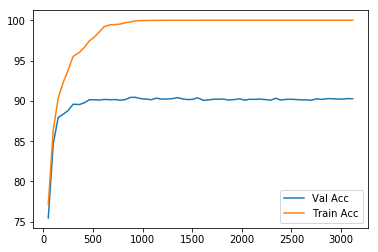

---Embedding size = 100---
Epoch: [1/10], Validation Acc: 90.24
Epoch: [2/10], Validation Acc: 89.94
Epoch: [3/10], Validation Acc: 89.74
Epoch: [4/10], Validation Acc: 89.66
Epoch: [5/10], Validation Acc: 89.88
Epoch: [6/10], Validation Acc: 89.84
Epoch: [7/10], Validation Acc: 89.92
Epoch: [8/10], Validation Acc: 89.9
Epoch: [9/10], Validation Acc: 89.94
Epoch: [10/10], Validation Acc: 89.94


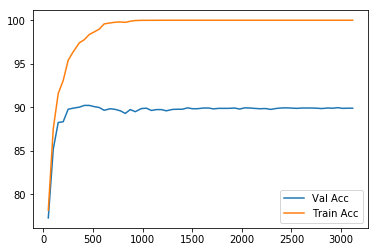

---Embedding size = 200---
Epoch: [1/10], Validation Acc: 90.4
Epoch: [2/10], Validation Acc: 89.24
Epoch: [3/10], Validation Acc: 90.32
Epoch: [4/10], Validation Acc: 90.16
Epoch: [5/10], Validation Acc: 90.12
Epoch: [6/10], Validation Acc: 90.2
Epoch: [7/10], Validation Acc: 90.18
Epoch: [8/10], Validation Acc: 90.14
Epoch: [9/10], Validation Acc: 90.18
Epoch: [10/10], Validation Acc: 90.14


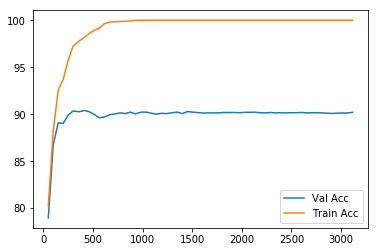

---Embedding size = 300---
Epoch: [1/10], Validation Acc: 90.56
Epoch: [2/10], Validation Acc: 89.86
Epoch: [3/10], Validation Acc: 89.7
Epoch: [4/10], Validation Acc: 89.9
Epoch: [5/10], Validation Acc: 90.08
Epoch: [6/10], Validation Acc: 90.12
Epoch: [7/10], Validation Acc: 90.18
Epoch: [8/10], Validation Acc: 90.08
Epoch: [9/10], Validation Acc: 90.08
Epoch: [10/10], Validation Acc: 90.12


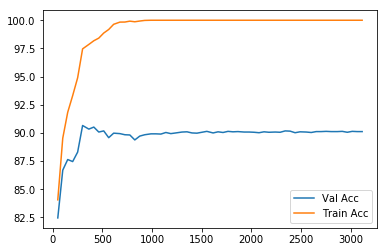

---Embedding size = 500---
Epoch: [1/10], Validation Acc: 89.34
Epoch: [2/10], Validation Acc: 89.52
Epoch: [3/10], Validation Acc: 89.82
Epoch: [4/10], Validation Acc: 89.7
Epoch: [5/10], Validation Acc: 89.82
Epoch: [6/10], Validation Acc: 89.78
Epoch: [7/10], Validation Acc: 89.86
Epoch: [8/10], Validation Acc: 89.76
Epoch: [9/10], Validation Acc: 89.78
Epoch: [10/10], Validation Acc: 89.94


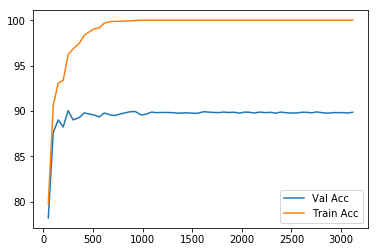

In [12]:
# Reset model
max_vocab_size = 50000
n_gram = 2
token2id, id2token = build_vocab(all_train_tokens, n_gram)
train_data_indices = token2index_dataset(train_data_tokens, n_gram)
val_data_indices = token2index_dataset(val_data_tokens, n_gram)
test_data_indices = token2index_dataset(test_data_tokens, n_gram)
train_dataset = ImdbDataset(train_data_indices, train_targets, n_gram)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = ImdbDataset(val_data_indices, val_targets, n_gram)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

test_dataset = ImdbDataset(test_data_indices, test_targets, n_gram)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)
for i in [50, 100, 200, 300, 500]:
    print('---Embedding size = {}---'.format(i))

    # run the model
    _, rec = run_model_conf(2, i, 10, 0.01,  'embed_{}'.format(i))

### Optimizer

We are now using Adam as optimizer, and the result is above (`embed_200`). We now use SGD and see if this can enhance the result

Epoch: [1/10], Validation Acc: 50.32
Epoch: [2/10], Validation Acc: 53.76
Epoch: [3/10], Validation Acc: 60.06
Epoch: [4/10], Validation Acc: 57.46
Epoch: [5/10], Validation Acc: 57.3
Epoch: [6/10], Validation Acc: 62.48
Epoch: [7/10], Validation Acc: 60.86
Epoch: [8/10], Validation Acc: 56.78
Epoch: [9/10], Validation Acc: 61.74
Epoch: [10/10], Validation Acc: 63.36


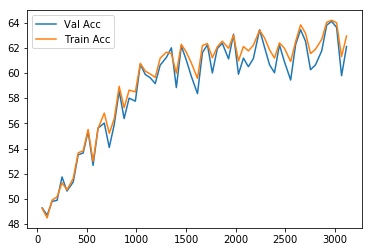

In [14]:
model = BagOfNGram(len(id2token), 200, 2).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer_SGD = torch.optim.SGD(model.parameters(), lr=learning_rate)
_, rec = run_model(model, criterion, optimizer_SGD, 10, 'SGD')

### Learning rate

| n-gram | vocabulary size | embedding size | max_sentence_length | learning_rate | optimizer | epoch |
| ------ | --------------- | -------------- | ------------------- | ------------- | --------- | ----- |
| 2 | 5000 |200| 1000 | **[0.1, 0.05, 0.01, 0.005, 0.001]** | Adam | 10 |

---Learning Rate = 0.1---
Epoch: [1/10], Validation Acc: 89.44
Epoch: [2/10], Validation Acc: 88.68
Epoch: [3/10], Validation Acc: 87.6
Epoch: [4/10], Validation Acc: 87.18
Epoch: [5/10], Validation Acc: 88.02
Epoch: [6/10], Validation Acc: 86.86
Epoch: [7/10], Validation Acc: 87.3
Epoch: [8/10], Validation Acc: 87.88
Epoch: [9/10], Validation Acc: 87.52
Epoch: [10/10], Validation Acc: 87.9


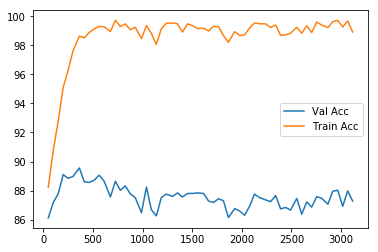

430.3971643447876 sec. Elapsed
---Learning Rate = 0.05---
Epoch: [1/10], Validation Acc: 89.82
Epoch: [2/10], Validation Acc: 89.1
Epoch: [3/10], Validation Acc: 88.76
Epoch: [4/10], Validation Acc: 89.08
Epoch: [5/10], Validation Acc: 88.8
Epoch: [6/10], Validation Acc: 88.38
Epoch: [7/10], Validation Acc: 86.6
Epoch: [8/10], Validation Acc: 87.78
Epoch: [9/10], Validation Acc: 87.52
Epoch: [10/10], Validation Acc: 88.26


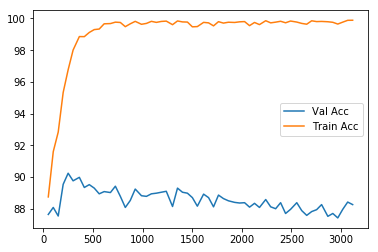

410.55744552612305 sec. Elapsed
---Learning Rate = 0.01---
Epoch: [1/10], Validation Acc: 90.08
Epoch: [2/10], Validation Acc: 89.18
Epoch: [3/10], Validation Acc: 89.82
Epoch: [4/10], Validation Acc: 90.1
Epoch: [5/10], Validation Acc: 90.08
Epoch: [6/10], Validation Acc: 90.1
Epoch: [7/10], Validation Acc: 90.14
Epoch: [8/10], Validation Acc: 90.16
Epoch: [9/10], Validation Acc: 90.12
Epoch: [10/10], Validation Acc: 90.14


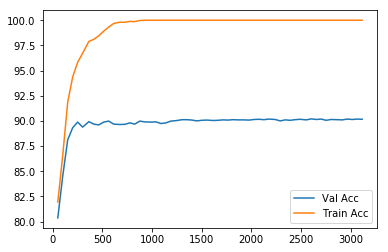

426.60418128967285 sec. Elapsed
---Learning Rate = 0.005---
Epoch: [1/10], Validation Acc: 89.38
Epoch: [2/10], Validation Acc: 89.82
Epoch: [3/10], Validation Acc: 90.2
Epoch: [4/10], Validation Acc: 90.4
Epoch: [5/10], Validation Acc: 90.38
Epoch: [6/10], Validation Acc: 90.26
Epoch: [7/10], Validation Acc: 90.3
Epoch: [8/10], Validation Acc: 90.32
Epoch: [9/10], Validation Acc: 90.28
Epoch: [10/10], Validation Acc: 90.32


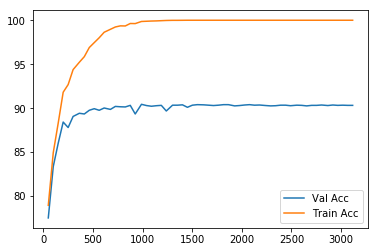

401.5429964065552 sec. Elapsed
---Learning Rate = 0.001---
Epoch: [1/10], Validation Acc: 81.6
Epoch: [2/10], Validation Acc: 87.54
Epoch: [3/10], Validation Acc: 88.74
Epoch: [4/10], Validation Acc: 89.66
Epoch: [5/10], Validation Acc: 90.06
Epoch: [6/10], Validation Acc: 90.38
Epoch: [7/10], Validation Acc: 90.46
Epoch: [8/10], Validation Acc: 90.52
Epoch: [9/10], Validation Acc: 90.44
Epoch: [10/10], Validation Acc: 90.68


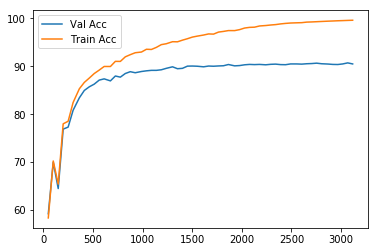

378.8743917942047 sec. Elapsed


In [34]:
for i in [0.1, 0.05, 0.01, 0.005, 0.001]:
    print('---Learning Rate = {}---'.format(i))
    tic = time.time()
    _, rec = run_model_conf(2, 200, 10, i,  'learnRate_' + str(i).replace('.', '_'))
    toc = time.time()
    print(toc-tic, 'sec. Elapsed')

### Linear Annealing of learning rate

From 0.01 to 0.001

---Annealing Learning Rate = 0.0055---
Epoch: [1/10], Validation Acc: 89.24
---Annealing Learning Rate = 0.0050---
Epoch: [2/10], Validation Acc: 90.42
---Annealing Learning Rate = 0.0045---
Epoch: [3/10], Validation Acc: 89.96
---Annealing Learning Rate = 0.0040---
Epoch: [4/10], Validation Acc: 89.92
---Annealing Learning Rate = 0.0035---
Epoch: [5/10], Validation Acc: 90.02
---Annealing Learning Rate = 0.0030---
Epoch: [6/10], Validation Acc: 90.0
---Annealing Learning Rate = 0.0025---
Epoch: [7/10], Validation Acc: 90.1
---Annealing Learning Rate = 0.0020---
Epoch: [8/10], Validation Acc: 90.02
---Annealing Learning Rate = 0.0015---
Epoch: [9/10], Validation Acc: 89.96
---Annealing Learning Rate = 0.0010---
Epoch: [10/10], Validation Acc: 90.06


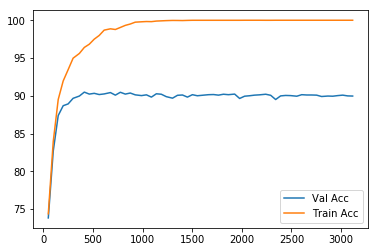

385.71788001060486 sec. Elapsed


In [35]:
tic = time.time()
def run_model_annealing(num_epochs, fig_name):
    '''
    Main function to train the model.
    '''
    iter_num= 0
    record = {
        'iter_num':[],
        'val_acc':[],
        'train_acc':[]
    }
    # Initialize model
    model = BagOfNGram(len(id2token), 200, 2).cuda()
    criterion = torch.nn.CrossEntropyLoss()    
    for epoch in range(num_epochs):
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0055 - 0.0005* epoch)  
        print('---Annealing Learning Rate = {:.4f}---'.format(0.0055 - 0.0005* epoch))
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            iter_num += 1
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch.cuda(), length_batch.cuda())
            loss = criterion(outputs.cpu(), label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and (i+1) % 50 == 0:
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                record['iter_num'].append(iter_num)
                record['val_acc'].append(val_acc)
                record['train_acc'].append(train_acc)
            del outputs
        val_acc = test_model(val_loader, model)
        print('Epoch: [{}/{}], Validation Acc: {}'.format( 
                   epoch+1, num_epochs, val_acc))
            
    plt.clf()
    plt.cla()
    plt.plot(record['iter_num'], record['val_acc'], label = 'Val Acc')
    plt.plot(record['iter_num'], record['train_acc'], label = 'Train Acc')
    plt.legend()
    plt.savefig('./img/'+fig_name+'.png')
    plt.savefig('./img/'+fig_name+'.eps')
    plt.show()
    torch.cuda.empty_cache()
    return model, record
_, rec = run_model_annealing(10, 'annealing')
toc = time.time()
print(toc-tic, 'sec. Elapsed')

### Epoch

| n-gram | vocabulary size | embedding size | max_sentence_length | learning_rate | optimizer | epoch |
| ------ | --------------- | -------------- | ------------------- | ------------- | --------- | ----- |
| 2 | 5000 |200| 1000 | 0.001| Adam | ≤20 |

We are going to a epoch of 20 and see which is the best epoch by the validation accuracy after each epoch.

---Epoch = 20---
Epoch: [1/20], Validation Acc: 80.64
Epoch: [2/20], Validation Acc: 86.68
Epoch: [3/20], Validation Acc: 88.24
Epoch: [4/20], Validation Acc: 89.62
Epoch: [5/20], Validation Acc: 89.84
Epoch: [6/20], Validation Acc: 90.08
Epoch: [7/20], Validation Acc: 90.18
Epoch: [8/20], Validation Acc: 90.48
Epoch: [9/20], Validation Acc: 90.44
Epoch: [10/20], Validation Acc: 90.36
Epoch: [11/20], Validation Acc: 90.42
Epoch: [12/20], Validation Acc: 90.32
Epoch: [13/20], Validation Acc: 90.26
Epoch: [14/20], Validation Acc: 90.24
Epoch: [15/20], Validation Acc: 90.16
Epoch: [16/20], Validation Acc: 90.14
Epoch: [17/20], Validation Acc: 90.14
Epoch: [18/20], Validation Acc: 90.3
Epoch: [19/20], Validation Acc: 90.3
Epoch: [20/20], Validation Acc: 90.24


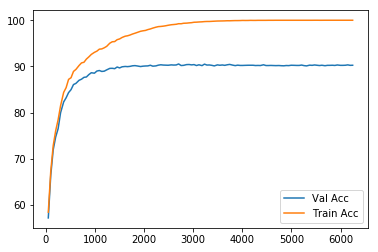

In [43]:
for i in [20]:
    print('---Epoch = {}---'.format(i))
    # run the model
    _, rec = run_model_conf(2, 200, i, 0.001,  'epoch_{}'.format(i))

### Tokenization schemes

Run the following script, or skip this cell and directly load the pickle file.

In [ ]:
from nltk.stem.lancaster import LancasterStemmer
stemmer= LancasterStemmer()

def stemming_token(data_tokens):
    data_tokens_stem = []
    for data_ in data_tokens:
        data_tokens_stem.append( [stemmer.stem(word_) for word_ in data_] )
    return data_tokens_stem

train_data_tokens_stem = stemming_token(train_data_tokens)
val_data_tokens_stem = stemming_token(val_data_tokens)
test_data_tokens_stem = stemming_token(test_data_tokens)

all_train_tokens_stem = create_all_tokens(train_data_tokens_stem)

pkl.dump(val_data_tokens_stem, open("val_data_tokens_stem.p", "wb"))
pkl.dump(test_data_tokens_stem, open("test_data_tokens_stem.p", "wb"))
pkl.dump(train_data_tokens_stem, open("train_data_tokens_stem.p", "wb"))
pkl.dump(all_train_tokens_stem, open("all_train_tokens_stem.p", "wb"))

In [45]:
val_data_tokens_stem   = pkl.load(open("val_data_tokens_stem.p", "rb"))
test_data_tokens_stem  = pkl.load(open("test_data_tokens_stem.p", "rb"))
train_data_tokens_stem = pkl.load(open("train_data_tokens_stem.p", "rb"))
all_train_tokens_stem  = pkl.load(open("all_train_tokens_stem.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))
print ("Total number of tokens in train dataset is {}, {}, {}, {}".format(*[len(x) for x in all_train_tokens]))

In [47]:
n_gram = 2
token2id_stem, id2token_stem = build_vocab(all_train_tokens_stem, n_gram)

In [49]:
train_data_indices_stem = token2index_dataset(train_data_tokens_stem, n_gram, token2id_stem)
val_data_indices_stem = token2index_dataset(val_data_tokens_stem, n_gram, token2id_stem)
test_data_indices_stem = token2index_dataset(test_data_tokens_stem, n_gram, token2id_stem)

In [51]:
# Need to be reset
train_dataset = ImdbDataset(train_data_indices_stem, train_targets, n_gram)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = ImdbDataset(val_data_indices_stem, val_targets, n_gram)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

test_dataset = ImdbDataset(test_data_indices_stem, test_targets, n_gram)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)

---Stemming tokenization---
Epoch: [1/8], Validation Acc: 81.28
Epoch: [2/8], Validation Acc: 87.14
Epoch: [3/8], Validation Acc: 88.52
Epoch: [4/8], Validation Acc: 89.34
Epoch: [5/8], Validation Acc: 89.94
Epoch: [6/8], Validation Acc: 90.16
Epoch: [7/8], Validation Acc: 90.18
Epoch: [8/8], Validation Acc: 90.12


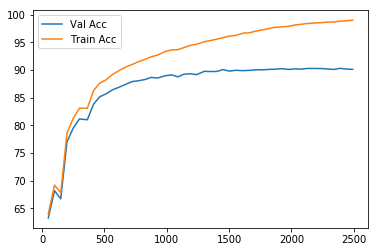

In [52]:
print('---Stemming tokenization---')
# run the model
_, rec = run_model_conf(2, 200, 8, 0.001,  'token_stem')

No significant improvement. Reset the variables

In [67]:
train_dataset = ImdbDataset(train_data_indices, train_targets, n_gram)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = ImdbDataset(val_data_indices, val_targets, n_gram)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

test_dataset = ImdbDataset(test_data_indices, test_targets, n_gram)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)

### Wrapping up

Epoch: [1/8], Validation Acc: 80.74
Epoch: [2/8], Validation Acc: 87.46
Epoch: [3/8], Validation Acc: 88.78
Epoch: [4/8], Validation Acc: 89.72
Epoch: [5/8], Validation Acc: 90.24
Epoch: [6/8], Validation Acc: 89.9
Epoch: [7/8], Validation Acc: 90.42
Epoch: [8/8], Validation Acc: 90.58


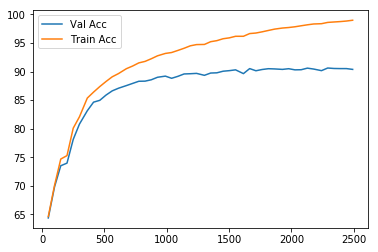

In [68]:
model_train, rec = run_model_conf(2, 200, 8, 0.001,  'wrapUp')

In [99]:
def test_model_cor_wrg(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    res = []
    cor = []
    wrg = []
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = (F.softmax(model(data_batch.cuda(), length_batch.cuda()), dim=1)).cpu()
        predicted = outputs.max(1, keepdim=True)[1] # The second output is the index of the largest output
        res += predicted.eq(labels.view_as(predicted)).reshape(1, -1).tolist()[0]
    for i in range(len(res)):
        if res[i]:
            cor.append(i)
        else:
            wrg.append(i)
    return cor, wrg

In [100]:
cor, wrg = test_model_cor_wrg(val_loader, model_train)

#### Examples

In [147]:
n = np.random.choice(cor, 1)[0]
print('Example: Correct prediction\n' + ('Positive Review' if val_targets[n] else 'Negative Review'))
' '.join(val_data_tokens[n])

Example: Correct prediction
Negative Review


"this is the only movie that my wife and i have ever walked out on totally sucked we saw it in omaha even not funny at all looks like a 14 year old kid wrote the humor i ca n't believe these real politicians were actually in the movie awful"

In [152]:
n = np.random.choice(cor, 1)[0]
print('Example: Correct prediction\n' + ('Positive Review' if val_targets[n] else 'Negative Review'))
' '.join(val_data_tokens[n])

Example: Correct prediction
Positive Review


"sniper gives a true new meaning to war movies i remember movies about vietnam or wwii lots of firing everybody dies bam bam sniper takes war to a new level or refinement the movie certainly conveys all of the emotions it aims for the helplessness of humans in the jungle the hatred and eventual trust between beckett and miller and the rush of the moment when they pull the trigger a seemingly low budget film makes up for every flaw with action suspense and thrill because when it comes down to it it 's just one shot one kill"

In [255]:
n = np.random.choice(cor, 1)[0]
print('Example: Correct prediction\n' + ('Positive Review' if val_targets[n] else 'Negative Review'))
' '.join(val_data_tokens[n])

Example: Correct prediction
Negative Review


"i do n't understand how 2 of us receive such a high rating ... i thought that the first half dragged on and the second half did nt make sense followed by an unresolved climax which was not worth the trouble however i did like jared harris performance of john lennon which was worth the wasted 2 hours"

In [185]:
n = np.random.choice(wrg, 1)[0]
print('Example: Wrong prediction\nSupposed to be ' + ('Positive Review' if val_targets[n] else 'Negative Review'))
' '.join(val_data_tokens[n])

Example: Wrong prediction
Supposed to be Negative Review


"wonderful cast wasted on worthless script ten or so adults reunite at the summer camp they attended as juveniles could this ever happen in a million years it 's simply a fantasy and a boring one at that do they become teenagers again do they reenact their pranks games good times they may try but ultimately the answer is no is there any intrigue any suspense horror comedy none of the above how anyone can be entertained by this drivel is beyond me i wanted to like this movie i tried to like this movie but my brain refused"

In [192]:
n = np.random.choice(wrg, 1)[0]
print('Example: Wrong prediction\nSupposed to be ' + ('Positive Review' if val_targets[n] else 'Negative Review'))
' '.join(val_data_tokens[n])

Example: Wrong prediction
Supposed to be Negative Review


"aside from the horrendous acting and the ridiculous and ludicrous plot this movie was n't too bad unfortunately that does n't leave much movie not to suck do not waste your time on this film even if you find yourself suffering from insomnia as i did watch an infomercial instead"

In [232]:
n = np.random.choice(wrg, 1)[0]
print('Example: Wrong prediction\nSupposed to be ' + ('Positive Review' if val_targets[n] else 'Negative Review'))
' '.join(val_data_tokens[n])

Example: Wrong prediction
Supposed to be Positive Review


"loved this film real people great acting humour unpredictable the characters were believable and you really connected with them if you 're looking for a film about slightly offbeat characters outside the mainstream of society and how they help each other this would be a good choice"

### Final test

Concatenate train and val data and run test on test data. 

In [203]:
train_val_data_indices = train_data_indices + val_data_indices
train_val_targets = train_targets + val_targets

In [204]:
train_val_dataset = ImdbDataset(train_val_data_indices, train_val_targets, n_gram)
train_val_loader = torch.utils.data.DataLoader(dataset=train_val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

Epoch: [1/8], Test Acc: 82.884
Epoch: [2/8], Test Acc: 86.42
Epoch: [3/8], Test Acc: 88.736
Epoch: [4/8], Test Acc: 89.412
Epoch: [5/8], Test Acc: 89.988
Epoch: [6/8], Test Acc: 90.02
Epoch: [7/8], Test Acc: 90.144
Epoch: [8/8], Test Acc: 90.232


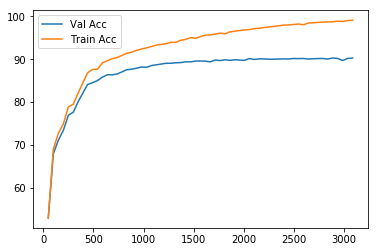

In [212]:
model = BagOfNGram(len(id2token), 200, 2).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs= 8
fig_name  = 'test'

iter_num= 0
record = {
    'iter_num':[],
    'val_acc':[],
    'train_acc':[]
}

# Initialize model
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_val_loader):
        model.train()
        iter_num += 1
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch.cuda(), length_batch.cuda())
        loss = criterion(outputs.cpu(), label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and (i+1) % 50 == 0:
            val_acc = test_model(test_loader, model)
            train_acc = test_model(train_val_loader, model)
            record['iter_num'].append(iter_num)
            record['val_acc'].append(val_acc)
            record['train_acc'].append(train_acc)
        del outputs
    val_acc = test_model(test_loader, model)
    print('Epoch: [{}/{}], Test Acc: {}'.format( 
               epoch+1, num_epochs, val_acc))

plt.clf()
plt.cla()
plt.plot(record['iter_num'], record['val_acc'], label = 'Val Acc')
plt.plot(record['iter_num'], record['train_acc'], label = 'Train Acc')
plt.legend()
plt.savefig('./img/'+fig_name+'.png')
plt.savefig('./img/'+fig_name+'.eps')
plt.show()
torch.cuda.empty_cache()


1-gram, embed = 100, acc = 85.84

2-gram, embed = 100, acc = 89.22